In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


One of the main issues with credit card fraud detection is the massive class imbalance. So we will use precision. 

In [7]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [3]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
percentages = data['Class'].value_counts(normalize=True) * 100
print(percentages)

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


As predicted, there is a massive class imbalance already visible. Accuracy is completely useless as a scoring metric. Instead, I evaluate using precision, recall, and PR AUC, with a focus on maximizing recall while maintaining acceptable precision. We start by standardizing the data

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = data.drop(columns=['Class'])  # all scaled features only
y = data['Class']
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [9]:
X_rep = X.drop(columns = 'Amount')

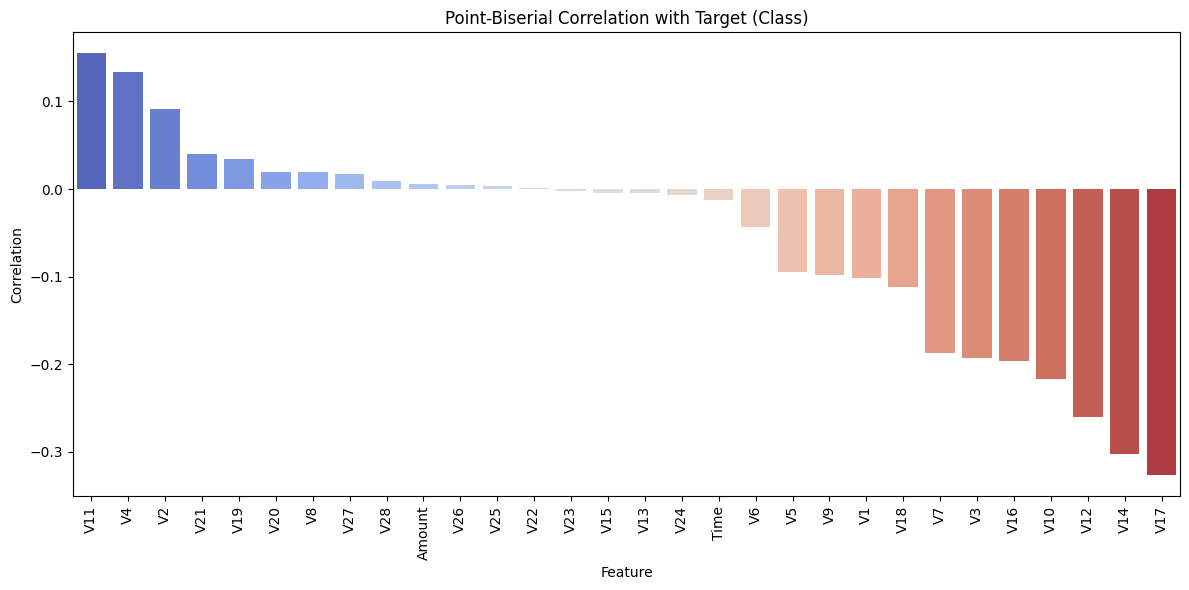

In [10]:
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns

correlations = {}

for col in X.columns:
    corr, _ = pointbiserialr(X[col], y)
    correlations[col] = corr


corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=corr_df.index, y=corr_df['correlation'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Point-Biserial Correlation with Target (Class)')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

Correlation is with respect to fraud (class = 1)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.0, 'Feature Correlation Matrix')

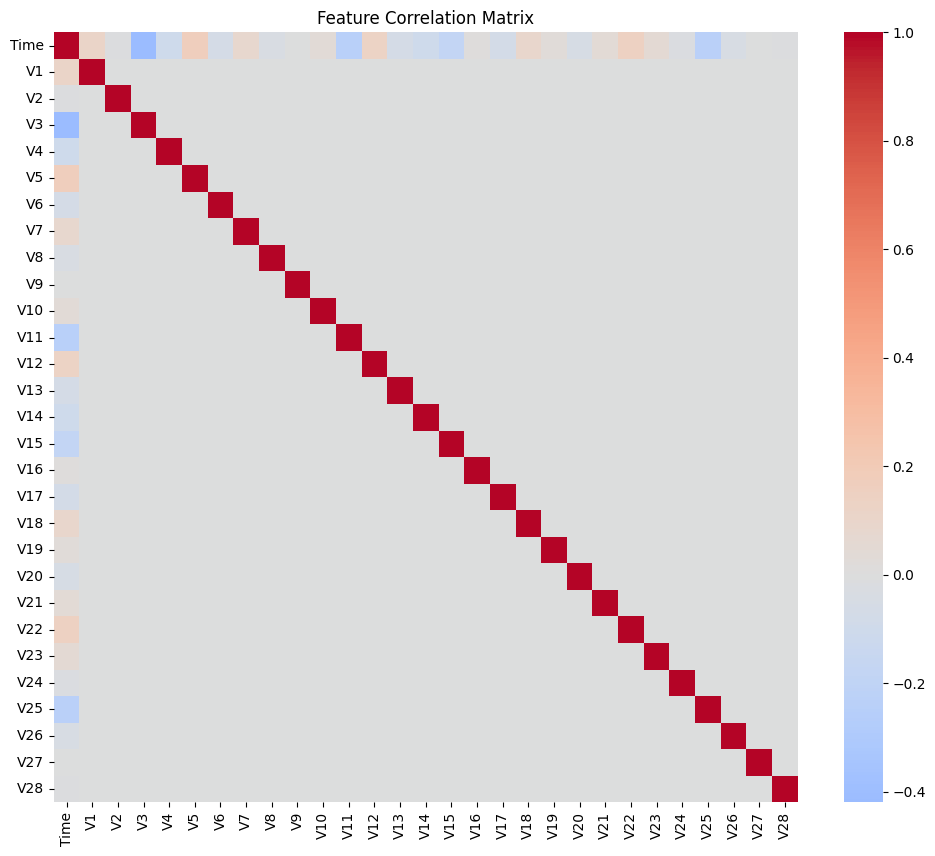

In [8]:
corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

Low correlation between any of the features, so the features are mostly independent. Linear correlation between the features and the class is also low. So linear/logistic regression is inadvisable. Can this be separated in PCA?

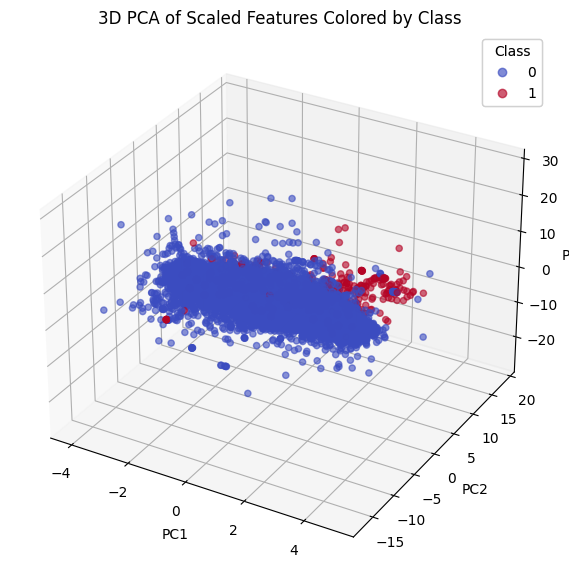

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=y, cmap='coolwarm', alpha=0.6, s=20
)

ax.set_title('3D PCA of Scaled Features Colored by Class')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)

plt.show()

Tried to check if there was any grounds to separate using PCA, but that clearly is not possible. 

**Aim of the model: To reduce the amount of money lost to fraud as much as possible, whilst ensuring false positives are low to reduce workload**

So now we proceed onto the next step - we construct models. We have established that the features are by and large independent and only weakly linearly correlated with the target variable. We will still use logistic regression as a baseline, but we will focus on applying Random Forests and XGBoost to model both non linear relations and due to the large amount of data. They also have built in mechanisms to deal with the massive class imbalance. 

The scoring mechanism will prioritize recall, especially of the fraud class. It is better to be safe than sorry.

We will split the data into 2, one with high transaction amounts and one with lower. We will apply models to maximise recall in the high transaction amounts, and f1 score, the harmonic mean between recall and precision, with low transaction amounts. This will ensure less is lost to high transactions whilst reducing workload as much as possible. We start by establishing a threshold over which we split the two models

In [11]:

cutoff_amount = data['Amount'].quantile(0.80)

print(f"80th percentile cutoff: {cutoff_amount:.2f}")


low_value_data = data[data['Amount'] <= cutoff_amount]
high_value_data = data[data['Amount'] > cutoff_amount]

print(f"Low-value transactions (<= {cutoff_amount:.2f}): {len(low_value_data)}")
print(f"High-value transactions (> {cutoff_amount:.2f}): {len(high_value_data)}")

80th percentile cutoff: 100.00
Low-value transactions (<= 100.00): 228299
High-value transactions (> 100.00): 56508


In [12]:
len(X_low)

228299

In [13]:
len(y_low)

228299

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Fraud rate: {y_train.mean():.4f}")

from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)

Train shape: (227845, 30), Test shape: (56962, 30)
Fraud rate: 0.0017


Now Logistic Regression. This will not work well. 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV

lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000))
])

center = 0.0004641
fine_C = np.geomspace(center / 3, center * 3, 20)

param_grid = {
    'lr__C': fine_C,
    'lr__solver': ['liblinear']
}

lr_search = HalvingGridSearchCV(lr_pipe, param_grid, cv=3, scoring=f1_scorer, verbose=1)
lr_search.fit(X_train, y_train)

# Evaluation
print(f"Best params: {lr_search.best_params_}")
print(f"Best CV AUC: {lr_search.best_score_:.4f}")
y_pred_lr = lr_search.predict_proba(X_test)[:, 1]
print(f"Test AUC: {roc_auc_score(y_test, y_pred_lr):.4f}")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 25316
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 25316
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 75948
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 227844
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'lr__C': 0.0013923, 'lr__solver': 'liblinear'}
Best CV AUC: 0.1203
Test AUC: 0.9751


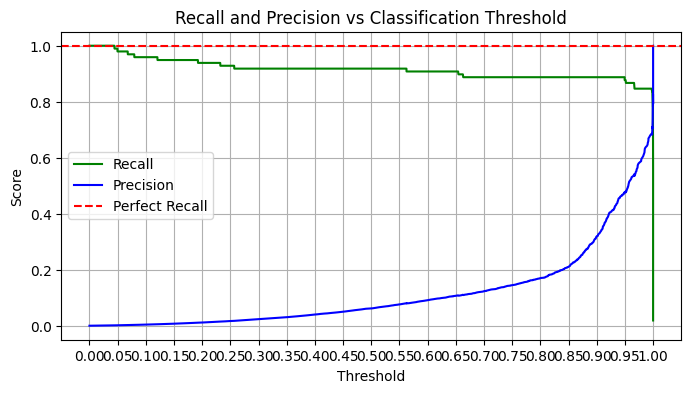

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = lr_search.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.axhline(y=1.0, color='r', linestyle='--', label='Perfect Recall')
step = 0.05
xticks = np.arange(0, 1.01, step)
plt.xticks(xticks)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall and Precision vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show() 

In [21]:
def get_threshold_and_precision_for_recall(recall, precision, thresholds, target):
    
    valid_indices = [i for i, r in enumerate(recall[:-1]) if r >= target]
    if valid_indices:
        max_index = max(valid_indices)  
        return thresholds[max_index], precision[max_index]
    return None, None

for target in [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86]:
    thresh, prec = get_threshold_and_precision_for_recall(recall, precision, thresholds, target)
    if thresh is not None:
        print(f"Recall >= {target}: threshold = {thresh:.8f}, precision = {prec:.4f}")
    else:
        print(f"No threshold found for recall >= {target}")

Recall >= 0.8: threshold = 0.99901507, precision = 0.7117
Recall >= 0.81: threshold = 0.99880554, precision = 0.7080
Recall >= 0.82: threshold = 0.99872010, precision = 0.7105
Recall >= 0.83: threshold = 0.99859123, precision = 0.7069
Recall >= 0.84: threshold = 0.99708102, precision = 0.6860
Recall >= 0.85: threshold = 0.96660264, precision = 0.5385
Recall >= 0.86: threshold = 0.96625706, precision = 0.5414


Ideal threshold is 0.99958044 then. 

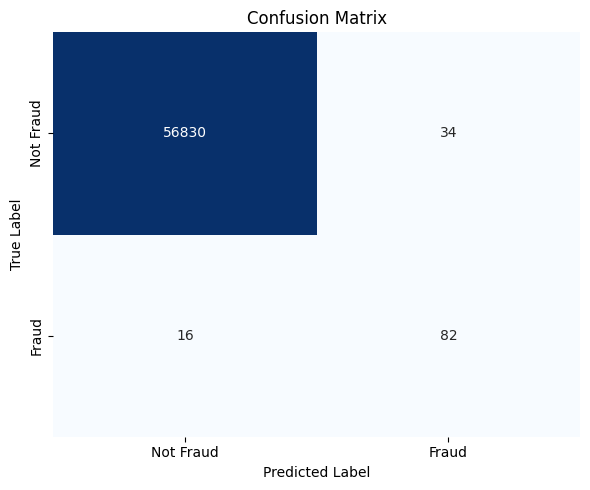

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

lrthreshold = 0.99859123
y_pred_label = (y_pred_lr >= lrthreshold).astype(int)
cm = confusion_matrix(y_test, y_pred_label)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

lrmodel = lr_search.best_estimator_

This is not very good. But it is a baseline. Now we apply Random Forests

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 8438
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 8438
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 20
n_resources: 25314
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 7
n_resources: 75942
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 3
n_resources: 227826
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'rf__max_depth': 30, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}
Best CV AUC: 0.8337
Test AUC: 0.9527


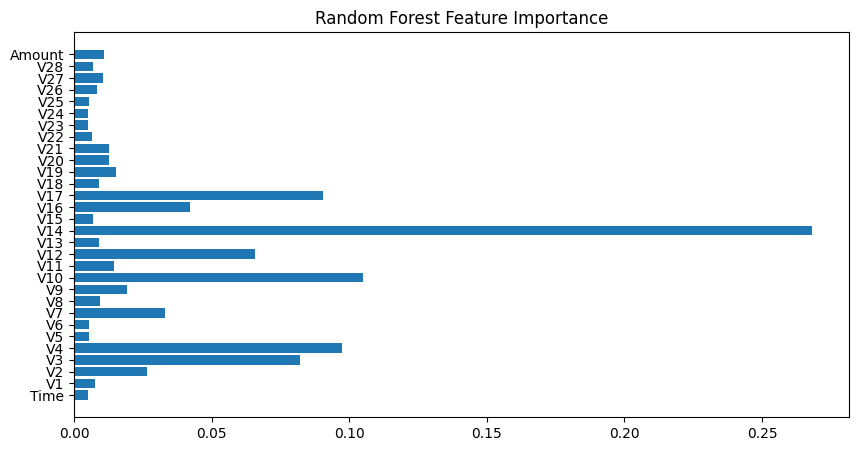

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score

rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(class_weight='balanced_subsample', random_state=42))
])

param_dist = {
    'rf__n_estimators': np.arange(50, 300, 50),
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

rf_search = HalvingGridSearchCV(
    rf_pipe,
    param_grid=param_dist,
    scoring=f1_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)

print(f"Best params: {rf_search.best_params_}")
print(f"Best CV AUC: {rf_search.best_score_:.4f}")
y_pred_rf = rf_search.predict_proba(X_test)[:, 1]
print(f"Test AUC: {roc_auc_score(y_test, y_pred_rf):.4f}")

importances = rf_search.best_estimator_.named_steps['rf'].feature_importances_
plt.figure(figsize=(10, 5))
plt.barh(X.columns, importances)
plt.title("Random Forest Feature Importance")
plt.show()

In [24]:
y_probs_rf = rf_search.predict_proba(X_test)[:, 1]  

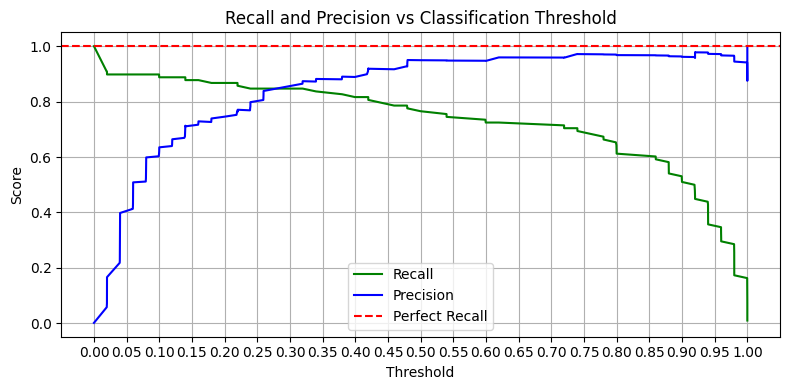

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rf, pos_label=1)

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.axhline(y=1.0, color='red', linestyle='--', label='Perfect Recall')

step = 0.05
xticks = np.arange(0, 1.01, step)
plt.xticks(xticks)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall and Precision vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def get_threshold_and_precision_for_recall(recall, precision, thresholds, target):
    valid_indices = [i for i, r in enumerate(recall[:-1]) if r >= target]
    if valid_indices:
        max_index = max(valid_indices)
        return thresholds[max_index], precision[max_index]
    return None, None

for target in  np.arange(0.8, 0.9, 0.01):
    thresh, prec = get_threshold_and_precision_for_recall(recall, precision, thresholds, target)
    if thresh is not None:
        print(f"Recall >= {target}: threshold = {thresh:.7f}, precision = {prec:.4f}")
    else:
        print(f"No threshold found for recall >= {target}")

Recall >= 0.8: threshold = 0.4198820, precision = 0.9186
Recall >= 0.81: threshold = 0.4198345, precision = 0.9195
Recall >= 0.8200000000000001: threshold = 0.3798582, precision = 0.8901
Recall >= 0.8300000000000001: threshold = 0.3399180, precision = 0.8817
Recall >= 0.8400000000000001: threshold = 0.3194536, precision = 0.8737
Recall >= 0.8500000000000001: threshold = 0.2199639, precision = 0.7706
Recall >= 0.8600000000000001: threshold = 0.2196899, precision = 0.7658
Recall >= 0.8700000000000001: threshold = 0.1599563, precision = 0.7288
Recall >= 0.8800000000000001: threshold = 0.1398812, precision = 0.7131
Recall >= 0.8900000000000001: threshold = 0.0996482, precision = 0.6154


Best is probably 0.2196899

Confusion Matrix:
[[56838    26]
 [   14    84]]


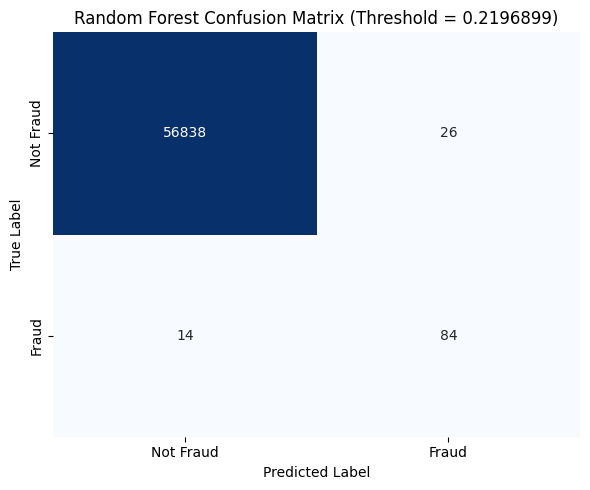

Recall at threshold 0.2196899: 0.8571


In [33]:

import seaborn as sns
import matplotlib.pyplot as plt

rfthreshold = 0.2196899

y_pred_rf_label = (y_probs_rf >= rfthreshold).astype(int)

cm = confusion_matrix(y_test, y_pred_rf_label)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Random Forest Confusion Matrix (Threshold = {rfthreshold})')
plt.tight_layout()
plt.show()

from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred_rf_label, pos_label=1)
print(f"Recall at threshold {rfthreshold}: {recall:.4f}")

Scale pos weight: 577.29
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 50
max_resources_: 200
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 50
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:14:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:14:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

----------
iter: 1
n_candidates: 7
n_resources: 50
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 150
Fitting 3 folds for each of 3 candidates, totalling 9 fits

XGBoost Search Time: 73.3 seconds

XGBOOST SEARCH RESULTS
Best Parameters: {'xgb__colsample_bytree': 0.8123620356542087, 'xgb__gamma': 0.19014286128198324, 'xgb__learning_rate': 0.2329984854528513, 'xgb__max_depth': 7, 'xgb__reg_alpha': 0.0596850157946487, 'xgb__reg_lambda': 1.2229163764267956, 'xgb__subsample': 0.7299924747454009, 'xgb__n_estimators': 150}
Best Score (CV Recall): 0.8551619976502999

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Test Recall (Class

<Figure size 1000x600 with 0 Axes>

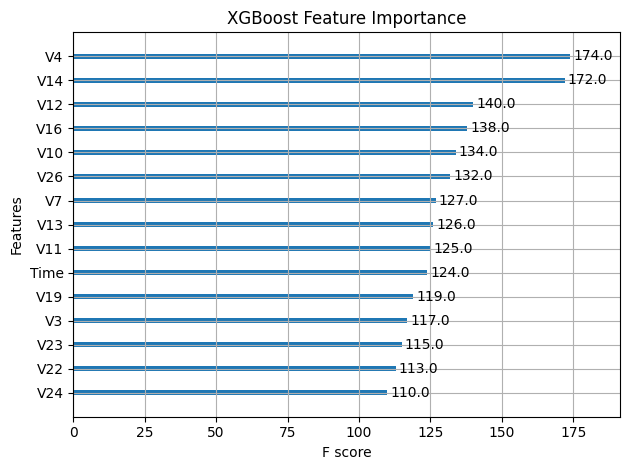


Search Details:
- Total candidates evaluated: 30
- Number of iterations: 3
- Time per candidate: 2.44 seconds


In [36]:
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore", message=".*Falling back to prediction using DMatrix.*")

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale pos weight: {scale_pos_weight:.2f}")

pipe_xgb = Pipeline([
    ('xgb', XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',     
        device='cuda',        
        random_state=42,
        n_estimators=50,
        n_jobs=-1
    ))
])

param_distributions = {
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.05, 0.25),
    'xgb__subsample': uniform(0.7, 0.3),
    'xgb__colsample_bytree': uniform(0.7, 0.3),
    'xgb__gamma': uniform(0, 0.2),
    'xgb__reg_alpha': uniform(0, 0.1),
    'xgb__reg_lambda': uniform(1, 0.5)
}

search_xgb = HalvingRandomSearchCV(
    pipe_xgb,
    param_distributions=param_distributions,
    n_candidates=20,
    scoring=f1_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    factor=3,
    resource='xgb__n_estimators',
    min_resources=50,
    max_resources=200,
    aggressive_elimination=True,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start = time.time()
search_xgb.fit(X_train, y_train)
xgb_time = time.time() - start
print(f"\nXGBoost Search Time: {xgb_time:.1f} seconds")

best_xgb = search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("XGBOOST SEARCH RESULTS")
print("="*50)
print("Best Parameters:", search_xgb.best_params_)
print("Best Score (CV Recall):", search_xgb.best_score_)
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"Test Recall (Class 1): {recall_score(y_test, y_pred_xgb):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

plt.figure(figsize=(10, 6))
try:
    plot_importance(best_xgb.named_steps['xgb'], max_num_features=15)
    plt.title("XGBoost Feature Importance")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

print(f"\nSearch Details:")
print(f"- Total candidates evaluated: {len(search_xgb.cv_results_['params'])}")
print(f"- Number of iterations: {search_xgb.n_iterations_}")
print(f"- Time per candidate: {xgb_time / len(search_xgb.cv_results_['params']):.2f} seconds")

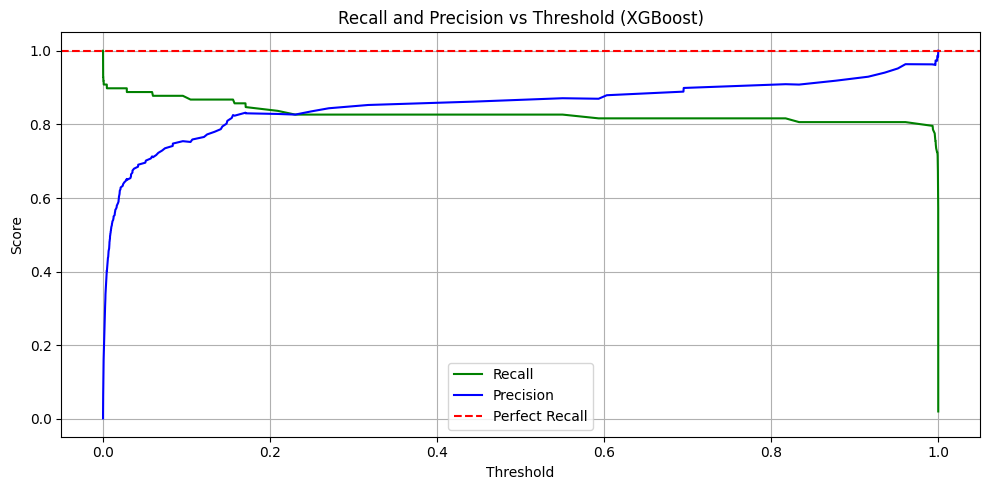

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb, pos_label=1)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.axhline(y=1.0, color='red', linestyle='--', label='Perfect Recall')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall and Precision vs Threshold (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
def get_thresholds_for_recalls(precision, recall, thresholds, targets):
    results = {}
    for target in targets:
        valid_idxs = [i for i, r in enumerate(recall[:-1]) if r >= target]
        if valid_idxs:
            idx = max(valid_idxs)
            thresh = thresholds[idx]
            prec = precision[idx]
            rec = recall[idx]
            results[target] = (thresh, prec, rec)
        else:
            results[target] = (None, None, None)
    return results

desired_recalls = [round(x, 2) for x in np.arange(0.88, 0.96, 0.01)]
results = get_thresholds_for_recalls(precision, recall, thresholds, desired_recalls)

for rec_val in desired_recalls:
    thresh, prec, rec = results[rec_val]
    if thresh is not None:
        print(f"Recall >= {rec_val}: Threshold = {thresh:.4f}, Precision = {prec:.4f}, Recall = {rec:.4f}")
    else:
        print(f"No threshold found for Recall >= {rec_val}")

Recall >= 0.88: Threshold = 0.0588, Precision = 0.7131, Recall = 0.8878
Recall >= 0.89: Threshold = 0.0284, Precision = 0.6519, Recall = 0.8980
Recall >= 0.9: Threshold = 0.0045, Precision = 0.4027, Recall = 0.9082
Recall >= 0.91: Threshold = 0.0007, Precision = 0.1630, Recall = 0.9184
Recall >= 0.92: Threshold = 0.0003, Precision = 0.0896, Recall = 0.9286
Recall >= 0.93: Threshold = 0.0000, Precision = 0.0175, Recall = 0.9388
Recall >= 0.94: Threshold = 0.0000, Precision = 0.0140, Recall = 0.9490
Recall >= 0.95: Threshold = 0.0000, Precision = 0.0108, Recall = 0.9592


Threshold is 0.0588

Confusion Matrix:
[[56829    35]
 [   12    86]]


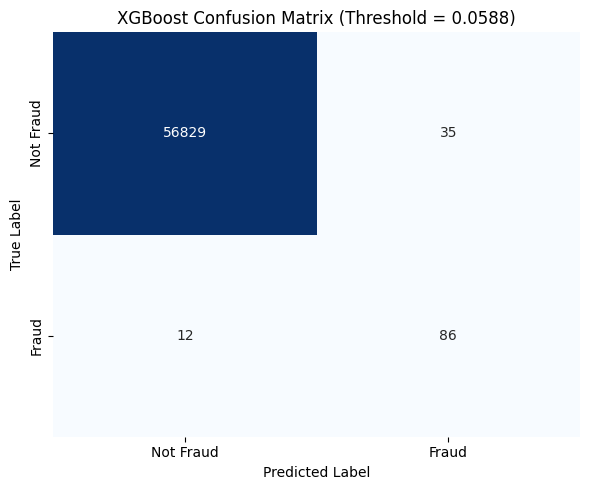

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgbthreshold = 0.0588
y_pred_xgb_label = (y_proba_xgb >= xgbthreshold).astype(int)

cm = confusion_matrix(y_test, y_pred_xgb_label)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'XGBoost Confusion Matrix (Threshold = {xgbthreshold})')
plt.tight_layout()
plt.show()

xgbmodel = best_xgb  

All of them miss a similar amount of false positives. What if we check if they are the same ones

In [40]:

fp_lr = set(X_test[(y_pred_label == 1) & (y_test == 0)].index)
fp_rf = set(X_test[(y_pred_rf_label == 1) & (y_test == 0)].index)
fp_xgb = set(X_test[(y_pred_xgb_label == 1) & (y_test == 0)].index)

print(f"False Positives LR: {len(fp_lr)}")
print(f"False Positives RF: {len(fp_rf)}")
print(f"False Positives XGB: {len(fp_xgb)}")

fp_all = fp_lr & fp_rf & fp_xgb  
fp_any = fp_lr | fp_rf | fp_xgb 

print(f"False Positives by ALL models: {len(fp_all)}")
print(f"False Positives by ANY model: {len(fp_any)}")

print(f"LR only false positives: {len(fp_lr - fp_rf - fp_xgb)}")
print(f"RF only false positives: {len(fp_rf - fp_lr - fp_xgb)}")
print(f"XGB only false positives: {len(fp_xgb - fp_lr - fp_rf)}")

print("\n" + "="*40 + "\n")
fn_lr = set(X_test[(y_pred_label == 0) & (y_test == 1)].index)
fn_rf = set(X_test[(y_pred_rf_label == 0) & (y_test == 1)].index)
fn_xgb = set(X_test[(y_pred_xgb_label == 0) & (y_test == 1)].index)

print(f"False Negatives (missed frauds) LR: {len(fn_lr)}")
print(f"False Negatives (missed frauds) RF: {len(fn_rf)}")
print(f"False Negatives (missed frauds) XGB: {len(fn_xgb)}")

fn_all = fn_lr & fn_rf & fn_xgb  
fn_any = fn_lr | fn_rf | fn_xgb  
print(f"Frauds missed by ALL models: {len(fn_all)}")
print(f"Frauds missed by ANY model: {len(fn_any)}")

print(f"LR only missed:  {len(fn_lr - fn_rf - fn_xgb)}")
print(f"RF only missed:  {len(fn_rf - fn_lr - fn_xgb)}")
print(f"XGB only missed: {len(fn_xgb - fn_lr - fn_rf)}")

False Positives LR: 34
False Positives RF: 26
False Positives XGB: 35
False Positives by ALL models: 11
False Positives by ANY model: 59
LR only false positives: 17
RF only false positives: 4
XGB only false positives: 13


False Negatives (missed frauds) LR: 16
False Negatives (missed frauds) RF: 14
False Negatives (missed frauds) XGB: 12
Frauds missed by ALL models: 12
Frauds missed by ANY model: 18
LR only missed:  4
RF only missed:  2
XGB only missed: 0


In [ ]:
missed_frauds = X_test.loc[list(fn_all)]
print(missed_frauds)

In [42]:
print(lrmodel.named_steps)

{'scaler': StandardScaler(), 'lr': LogisticRegression(C=0.0013923, class_weight='balanced', max_iter=1000,
                   solver='liblinear')}


In [43]:
rf_preds = (y_probs_rf >= rfthreshold).astype(int)
xgb_preds = (y_proba_xgb >= xgbthreshold).astype(int)
lr_preds = (y_pred_lr >= lrthreshold).astype(int)

weighted_votes = (rf_preds * 2) + (xgb_preds * 2) + (lr_preds * 1)

y_pred_hard = (weighted_votes >= 2).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_hard))
print(classification_report(y_test, y_pred_hard, digits=4))

[[56822    42]
 [   12    86]]
              precision    recall  f1-score   support

           0     0.9998    0.9993    0.9995     56864
           1     0.6719    0.8776    0.7611        98

    accuracy                         0.9991     56962
   macro avg     0.8358    0.9384    0.8803     56962
weighted avg     0.9992    0.9991    0.9991     56962



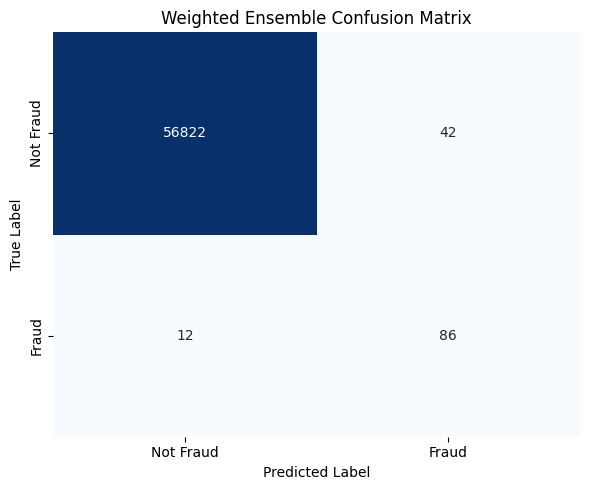

Precision: 0.6719
Recall: 0.8776


In [46]:
from sklearn.metrics import precision_score
cm = confusion_matrix(y_test, y_pred_hard)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Weighted Ensemble Confusion Matrix')
plt.tight_layout()
plt.show()

precision = precision_score(y_test, y_pred_hard, pos_label=1)
recall = recall_score(y_test, y_pred_hard, pos_label=1)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Now my plan is to split the dataset into low transaction amounts and high ones, specifically to reduce total amount of money lost. 

In [47]:
idx_test = X_test.index
original_amounts_test = data.loc[idx_test, 'Amount']
false_negatives_mask = (y_test == 1) & (y_pred_hard == 0)
fn_indices = idx_test[false_negatives_mask]
fn_amounts = data.loc[fn_indices, 'Amount']
total_fraud_amount_test = original_amounts_test[y_test == 1].sum()

fn_amount_sum = fn_amounts.sum()

percent_missed_amount = (fn_amount_sum / total_fraud_amount_test) * 100

print(f"Total fraudulent transaction amount (test set): {total_fraud_amount_test:.2f}")
print(f"Missed fraudulent transaction amount (test set): {fn_amount_sum:.2f}")
print(f"Percentage of fraud amount missed (test set): {percent_missed_amount:.4f}%")

Total fraudulent transaction amount (test set): 10644.93
Missed fraudulent transaction amount (test set): 1829.72
Percentage of fraud amount missed (test set): 17.1887%


This is good. Precision is also very high, so the auditors will not spend too much time being consumed by false positives. Now we repeat with the higher valued dataset. 

In [49]:
data['Amount']

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284807, dtype: float64

In [48]:

cost_per_false_positive = 20

false_negatives_mask = (y_test == 1) & (y_pred_hard == 0)
fn_indices = X_test.index[false_negatives_mask]
fn_amounts = data.loc[fn_indices, 'Amount']
fn_amount_sum = fn_amounts.sum()


false_positives_mask = (y_test == 0) & (y_pred_hard == 1)
fp_count = false_positives_mask.sum()
cost_per_false_positive = 20  
fp_total_cost = fp_count * cost_per_false_positive


total_fraud_amount_test = data.loc[X_test.index[y_test == 1], 'Amount'].sum()

total_loss = fn_amount_sum + fp_total_cost

loss_percent = (total_loss / total_fraud_amount_test) * 100

print(f"Total fraudulent transaction amount (test set): £{total_fraud_amount_test:.2f}")
print(f"Missed fraudulent transaction amount (FN): £{fn_amount_sum:.2f}")
print(f"Number of false positives (FP): {fp_count}")
print(f"Cost per false positive: £{cost_per_false_positive}")
print(f"Total cost of false positives: £{fp_total_cost:.2f}")
print(f"Total expected loss (FN + FP cost): £{total_loss:.2f}")
print(f"Loss as percentage of total fraud amount: {loss_percent:.4f}%")

Total fraudulent transaction amount (test set): £10644.93
Missed fraudulent transaction amount (FN): £1829.72
Number of false positives (FP): 42
Cost per false positive: £20
Total cost of false positives: £840.00
Total expected loss (FN + FP cost): £2669.72
Loss as percentage of total fraud amount: 25.0797%


So we have managed to reduce fraud significantly to only 25% of the losses. 